In [47]:
from ragraph.io.esl import from_esl
graph = from_esl(["./esl"])

import raesl.plot
figure = raesl.plot.mdm(
    graph,
    node_kinds=["component"],
)
figure.write_image("figures/dsm_components.svg")
figure.show()


In [48]:
import ragraph.plot

from utils import set_edge_weights
set_edge_weights(graph)

figure = raesl.plot.mdm(
    graph,
    node_kinds=["component", "variable"],
    depth=2,
    style=raesl.plot.Style(
        ragraph=ragraph.plot.Style(
            piemap=dict(
                display="weights",
                mode= "relative",
                fields=["weight"]
            ),
        )
    )
)

figure.write_image("figures/mdm_weights.svg")
figure.show()

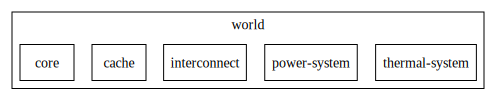

In [49]:
digraph = raesl.plot.functional_dependency_diagram(
    graph,
    root=graph["world"],
    levels=2,
)
digraph

In [50]:
figure = raesl.plot.mdm(
    graph,
    # node_kinds=["component", "variable", "function_spec", "design_spec", "relation_spec"],
    # edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=2,
)
figure.write_image("figures/mdm.svg")
# figure.show()

In [51]:
from raesl.plot.view_funcs import multi_domain
from ragraph.analysis import cluster

nodes, edges = multi_domain(
    graph,
    depth=4
)

relations = [n for n in nodes if n.kind == "relation_spec"]
variables = [n for n in nodes if n.kind == "variable"]
components = [n for n in nodes if n.kind == "component"]

# Cluster components
cluster.tarjans_scc(
    graph=graph,
    leafs = relations+variables,
)

# Reloaded MDM based on clustered graph.
figure = raesl.plot.mdm(
    graph,
    # node_kinds=["component", "variable", "function_spec", "design_spec", "relation_spec"],
    # edge_kinds=["functional_dependency", "mapping_dependency"],
    depth=2,
)
figure.write_image("figures/mdm_clustered.svg")
# figure.show()

In [52]:
from ragraph.analysis import sequence
import ragraph.plot

# Sequence functions.
_, _, sequenced_functions = sequence.utils.branchsort(algo=sequence.scc_tearing, graph=graph, algo_args=dict(inf=1, dep=1, mu=3), inplace=True, nodes=relations+variables)

# Reload figure based on sequence.
figure = ragraph.plot.mdm(
    leafs = components + sequenced_functions,
    edges = edges,
    style= ragraph.plot.Style(
        piemap=dict(
            display="labels",
            mode="relative",
            fields=graph.edge_labels
        ),
    )
)

figure.write_image("figures/mdm_clustered_sequenced.svg")
figure.show()